In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import supervision as sv

In [2]:
DEVICE=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
sam = sam_model_registry["vit_h"](checkpoint="weights/sam_vit_h_4b8939.pth").to(DEVICE)
predictor = SamPredictor(sam)

In [3]:
VIDEO_PATH = r"C:\Users\eleut\OneDrive\Desktop\Cows\20250401_123319.mp4"
assert os.path.exists(VIDEO_PATH), "Video file not found!"

In [4]:
MODEL_TYPE="vit_h"
CHECKPOINT_PATH="weights/sam_vit_h_4b8939.pth"

In [ ]:
mask_generator = SamAutomaticMaskGenerator(
    sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    min_mask_region_area=200
)
print(f"SAM loaded on {DEVICE}")

SAM loaded on cpu


In [6]:
def extract_frames(VIDEO_PATH, interval=1):
    cap = cv2.VideoCapture(VIDEO_PATH)
    if not cap.isOpened():
        print("Error: Could not open video")
        return [], []
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Video info: {fps} FPS, {total_frames} frames")
    
    frame_interval = max(1, int(fps * interval))
    frames = []
    frame_count = 0
    extracted_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        if frame_count % frame_interval == 0:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame_rgb)
            extracted_count += 1
            
        frame_count += 1
    
    cap.release()
    print(f"Extracted {extracted_count} frames from {frame_count} total frames")
    return frames, np.arange(0, frame_count/fps, 1/interval)[:len(frames)]

# Extract frames (1 frame per second)
VIDEO_PATH = r"C:\Users\eleut\OneDrive\Desktop\Cows\20250401_123319.mp4"
frames, times = extract_frames(VIDEO_PATH, interval=1)
print(f"You have {len(frames)} frames to process")


Video info: 30.00434401267618 FPS, 9983 frames
Extracted 333 frames from 9983 total frames
You have 333 frames to process


In [ ]:
def process_frames_with_sam(frames, start_idx=0, num_frames=5):
    results = []
    
    for i in range(start_idx, min(start_idx + num_frames, len(frames))):
        print(f"Processing frame {i+1}/{len(frames)}...")
        sam_result = mask_generator.generate(frames[i])
        results.append({
            'frame_idx': i,
            'time': times[i],
            'masks': sam_result,
            'frame': frames[i]
        })
        print(f"Generated {len(sam_result)} masks")
    
    return results

print(" Processing first 5 frames...")
sample_results = process_frames_with_sam(frames, num_frames=min(5, len(frames)))

 Processing first 5 frames...
Processing frame 1/333...
Generated 102 masks
Processing frame 2/333...
Generated 103 masks
Processing frame 3/333...
Generated 119 masks
Processing frame 4/333...
Generated 99 masks
Processing frame 5/333...
Generated 96 masks


 Visualizing first frame results...


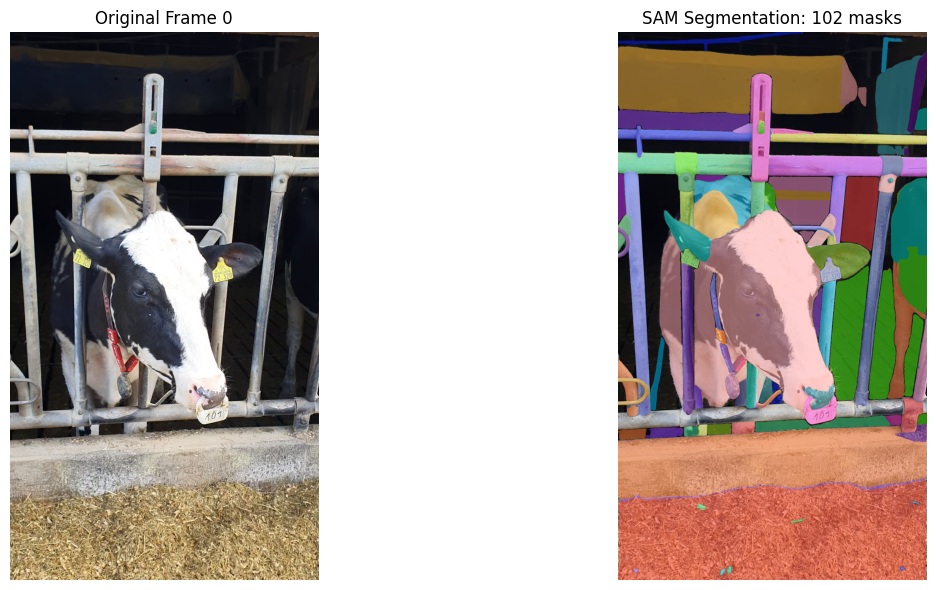

<Figure size 800x600 with 0 Axes>

In [ ]:
from supervision import ColorLookup

def visualize_frame_results(frame_result):
    frame_rgb   = frame_result['frame']
    sam_result  = frame_result['masks']
    frame_bgr = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR)
    mask_annotator = sv.MaskAnnotator()
    detections     = sv.Detections.from_sam(sam_result)
    annotated_image = mask_annotator.annotate(
        scene=frame_bgr,
        detections=detections,
        custom_color_lookup=ColorLookup.INDEX
    )
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].imshow(frame_rgb)
    ax[0].set_title(f'Original Frame {frame_result["frame_idx"]}')
    ax[0].axis('off')

    ax[1].imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    ax[1].set_title(f'SAM Segmentation: {len(sam_result)} masks')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

if sample_results:
    print(" Visualizing first frame results...")
    visualize_frame_results(sample_results[0])
    #visualize_frame_results(sample_results)
    # Show largest mask
    # largest_mask = max(sample_results[0]['masks'], key=lambda x: x['area'])
    # largest_mask = max(sample_results['masks'], key=lambda x: x['area'])
    plt.figure(figsize=(8, 6))
    # plt.imshow(largest_mask['segmentation'], cmap='gray')
    # plt.title(f"Largest Object Mask ({largest_mask['area']} pixels)")
    # plt.axis('off')
    # plt.show()
else:
    print("No results to visualize")